R mask:
 [[ True False]
 [False  True]]
C mask:
 [[ True False]
 [ True False]]


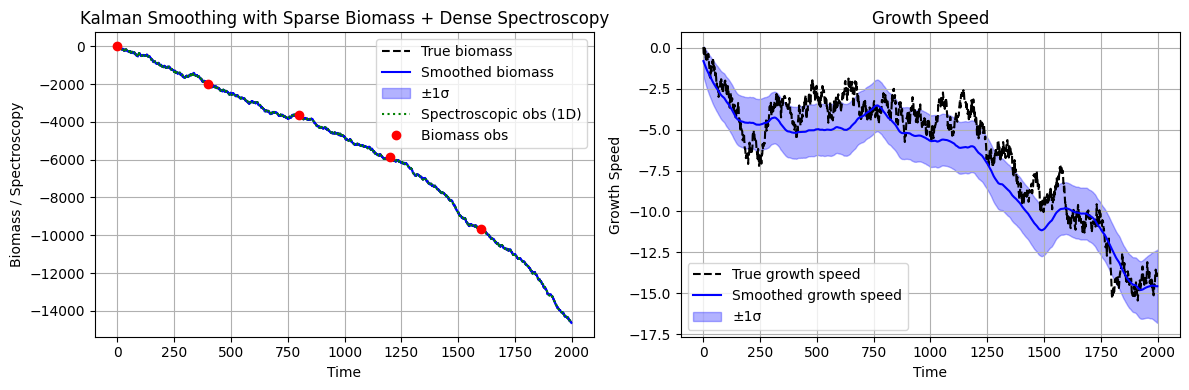

Learned observation matrix C:
 [[0.9998077  0.        ]
 [1.00000525 0.        ]]
Learned observation covariance R:
 [[0.03162587 0.        ]
 [0.         1.44105593]]
Determinant of learned observation covariance R:
 0.04557464968803187


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from mykalman import KalmanFilter

# --- Synthetic Setup ---

T = 2000                       # number of time steps
delta_t = 1.0                # time interval
# np.random.seed(42)

# True model parameters
A_true = np.array([[1, delta_t],
                   [0, 1]])
C_true = np.array([[1.0, 0.0],         # biomass
                   [1.0, 0.0]])        # spectroscopic (initial guess)

Q_true = np.diag([500.0, 0.05])
R_true = np.diag([1.0, 1.5])

# Generate latent states
x_true = np.zeros(T)
v_true = np.zeros(T)
x_true[0] = 8.0
v_true[0] = 0.05

for t in range(1, T):
    noise = np.random.multivariate_normal(mean=[0, 0], cov=Q_true)
    x_true[t] = x_true[t-1] + delta_t * v_true[t-1] + noise[0]  # biomass growth
    v_true[t] = v_true[t-1] + noise[1]       # slow growth drift

# Observations
biomass_obs = np.full(T, np.nan)
obs_indices = np.arange(0, T, T // 5)  # sparse observations every few time steps
obs_noise = np.random.multivariate_normal(mean=[0, 0], cov=R_true, size=T)

# Apply observation model
biomass_obs[obs_indices] = (
    C_true[0, 0] * x_true[obs_indices] +
    C_true[0, 1] * v_true[obs_indices] +
    obs_noise[obs_indices, 0]
)

spec_obs = (
    C_true[1, 0] * x_true +
    C_true[1, 1] * v_true +
    obs_noise[:, 1]
)

# Stack observations
Z = np.full((T, 2), np.nan)
Z[:, 0] = biomass_obs
Z[:, 1] = spec_obs
Z_masked = ma.masked_invalid(Z)

# --- Kalman Filter Setup ---

A = A_true.copy()
C = C_true.copy()
Q = Q_true.copy()
R = R_true.copy()

kf = KalmanFilter(
    transition_matrices=A,
    observation_matrices=C,
    transition_covariance=Q,
    observation_covariance=R,
    initial_state_mean=[x_true[0], v_true[0]],
    initial_state_covariance=np.eye(2)
)

R_mask = np.zeros_like(R, dtype=bool)
R_mask[0, 0] = True  # Mask for biomass observation
R_mask[1, 1] = True  # Spectroscopy observation is dense
print("R mask:\n", R_mask)

C_mask = np.zeros_like(C, dtype=bool)
C_mask[0, 0] = True  # Mask for biomass observation
C_mask[1, 0] = True  # Spectroscopy observation is dense
print("C mask:\n", C_mask)

# Optional: EM to refine C, R
# kf = kf.em(Z_masked, n_iter=20, em_vars=[
#     'observation_matrices',
#     # 'transition_covariance',
#     'observation_covariance'
# ])
kf = kf.em(Z_masked, n_iter=50, em_vars=[
    'observation_matrices',
    # 'transition_covariance',
    'observation_covariance'
], em_var_masks={
    'observation_matrices': C_mask,
    'observation_covariance': R_mask
})

# Run smoother
smoothed_state_mean, smoothed_state_covariance = kf.smooth(Z_masked)
x_smooth = smoothed_state_mean[:, 0]
v_smooth = smoothed_state_mean[:, 1]
x_std = np.sqrt([P[0, 0] for P in smoothed_state_covariance])
v_std = np.sqrt([P[1, 1] for P in smoothed_state_covariance])

# --- Plotting ---

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(x_true, 'k--', label="True biomass")
axs[0].plot(x_smooth, 'b-', label="Smoothed biomass")
axs[0].fill_between(np.arange(T), x_smooth - x_std, x_smooth + x_std, alpha=0.3, color='blue', label="±1σ")
axs[0].plot(spec_obs, 'g:', label="Spectroscopic obs (1D)")
axs[0].plot(biomass_obs, 'ro', label="Biomass obs")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Biomass / Spectroscopy")
axs[0].set_title("Kalman Smoothing with Sparse Biomass + Dense Spectroscopy")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(v_true, 'k--', label="True growth speed")
axs[1].plot(v_smooth, 'b-', label="Smoothed growth speed")
axs[1].fill_between(np.arange(T), v_smooth - v_std, v_smooth + v_std, alpha=0.3, color='blue', label="±1σ")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Growth Speed")
axs[1].set_title("Growth Speed")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Show learned parameters
print("Learned observation matrix C:\n", kf.observation_matrices)
print("Learned observation covariance R:\n", kf.observation_covariance)
print("Determinant of learned observation covariance R:\n", np.linalg.det(kf.observation_covariance))

In [6]:
observation_covariance = np.array([[1., 0., 2.0], [0.0, 1.5, 2.5], [2.0, 2.5, 3.0]])
print("Observation covariance matrix:\n", observation_covariance)
mask = np.array([True, True, False])  # Mask for the first observation (biomass)
print(mask)
observation_covariance[np.ix_(mask, mask)]
print("Masked observation covariance matrix:\n", observation_covariance[np.ix_(mask, mask)])

Observation covariance matrix:
 [[1.  0.  2. ]
 [0.  1.5 2.5]
 [2.  2.5 3. ]]
[ True  True False]
Masked observation covariance matrix:
 [[1.  0. ]
 [0.  1.5]]
